# Imports

In [407]:
import pandas as pd
import numpy as np
from scipy                 import stats  as ss

import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display       import Image
from sklearn.model_selection import KFold, cross_validate,GridSearchCV, RandomizedSearchCV, cross_val_score
from skopt import BayesSearchCV

from sklearn.linear_model import LogisticRegression

# Funções

In [408]:
def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is None:
        labels = np.unique(y_true)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def label_encoding(data, column):
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])
    pickle.dump( label_encoder, open( '../parameter/'+column+'_encoding.pkl', 'wb') )
    return data


def rescale_column(data, column_name):
    """
    Função para reescalar uma coluna específica do DataFrame para o intervalo [0, 1].

    Parâmetros:
        - data: DataFrame contendo os dados.
        - column_name: Nome da coluna a ser reescalada.

    Retorna:
        - DataFrame: dados com a coluna reescalada.
    """
    scaler = MinMaxScaler()
    data[[column_name]] = scaler.fit_transform(data[[column_name]])
    pickle.dump( scaler, open( '../parameter/'+column_name+'_scaler.pkl', 'wb') )
    return data


# Data Load

In [409]:
df = pd.read_csv('../data/credit_risk_dataset.csv')

In [410]:
df.rename(columns={
    'person_age': 'idade',
    'person_income': 'renda',
    'person_home_ownership': 'posse_casa',
    'person_emp_length': 'tempo_emprego',
    'loan_intent': 'finalidade_emprestimo',
    'loan_grade': 'grau_risco_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros_emprestimo',
    'loan_status': 'status_emprestimo',
    'loan_percent_income': 'relacao_emprestimo_renda',
    'cb_person_default_on_file': 'registro_inadimplencia',
    'cb_person_cred_hist_length': 'historico_credito'
}, inplace=True)

In [411]:
df.head()

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# 1.0 Data Description

In [412]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [413]:
df1.shape

(32581, 12)

## 1.2 Tipo dos Dados

In [414]:
df1.dtypes

idade                         int64
renda                         int64
posse_casa                   object
tempo_emprego               float64
finalidade_emprestimo        object
grau_risco_emprestimo        object
valor_emprestimo              int64
taxa_juros_emprestimo       float64
status_emprestimo             int64
relacao_emprestimo_renda    float64
registro_inadimplencia       object
historico_credito             int64
dtype: object

## 1.3 Check Na

In [415]:
df1.isna().sum()

idade                          0
renda                          0
posse_casa                     0
tempo_emprego                895
finalidade_emprestimo          0
grau_risco_emprestimo          0
valor_emprestimo               0
taxa_juros_emprestimo       3116
status_emprestimo              0
relacao_emprestimo_renda       0
registro_inadimplencia         0
historico_credito              0
dtype: int64

## 1.4 Fill Na

In [416]:
# df1 = df1.dropna()

In [417]:
df1.head()

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 1.5 Estatística Descritiva

In [418]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

### 1.5.1 Variáveis Numéricas

In [419]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,idade,20.00,144.00,124.00,27.734600,26.00,6.347981,2.581393,18.560825
1,renda,4000.00,6000000.00,5996000.00,66074.848470,55000.00,61982.167945,32.865349,2693.272776
2,tempo_emprego,0.00,123.00,123.00,4.789686,NaN,4.142565,2.614455,43.722338
3,valor_emprestimo,500.00,35000.00,34500.00,9589.371106,8000.00,6321.989624,1.192477,1.423565
4,taxa_juros_emprestimo,5.42,23.22,17.80,11.011695,NaN,3.240404,0.208550,-0.671609
5,status_emprestimo,0.00,1.00,1.00,0.218164,0.00,0.412999,1.364888,-0.137088
6,relacao_emprestimo_renda,0.00,0.83,0.83,0.170203,0.15,0.106780,1.064669,1.223687
7,historico_credito,2.00,30.00,28.00,5.804211,4.00,4.054939,1.661790,3.716194


### 1.5.2 Variáveis Categóricas

In [420]:
cat_attributes.describe().T

,count,unique,top,freq
posse_casa,32581,4,RENT,16446
finalidade_emprestimo,32581,6,EDUCATION,6453
grau_risco_emprestimo,32581,7,A,10777
registro_inadimplencia,32581,2,N,26836


## 1.6 Substituição de Dados Faltantes

### 1.6.1 Métodos Estatísticos

#### Média

In [421]:
# media_taxa_juros = df1['taxa_juros_emprestimo'].mean()
# df1['taxa_juros_emprestimo'].fillna(media_taxa_juros, inplace=True)

In [422]:
# media_tempo_emprego = df1['tempo_emprego'].mean()
# df1['tempo_emprego'].fillna(media_tempo_emprego, inplace=True)

# # precision 97.76

#### Mediana

In [423]:
# mediana_taxa_juros = df1['taxa_juros_emprestimo'].median()
# df1['taxa_juros_emprestimo'].fillna(mediana_taxa_juros, inplace=True)

# mediana_tempo_emprego = df1['tempo_emprego'].median()
# df1['tempo_emprego'].fillna(mediana_tempo_emprego, inplace=True)

#### Média + Desvio Padrão

### 1.6.2 Substituição com Machine Learning

#### K-NN

In [424]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(num_attributes), columns=num_attributes.columns)
pickle.dump( imputer, open( '../parameter/imputer_knn.pkl', 'wb') )
df1 = pd.concat([df_imputed, cat_attributes], axis=1)

#### Isolation Forest

# 2.0 Feature Engineering

In [425]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

In [426]:
df2.head()

,idade,renda,tempo_emprego,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,historico_credito,posse_casa,finalidade_emprestimo,grau_risco_emprestimo,registro_inadimplencia
0,22.0,59000.0,123.0,35000.0,16.02,1.0,0.59,3.0,RENT,PERSONAL,D,Y
1,21.0,9600.0,5.0,1000.0,11.14,0.0,0.10,2.0,OWN,EDUCATION,B,N
2,25.0,9600.0,1.0,5500.0,12.87,1.0,0.57,3.0,MORTGAGE,MEDICAL,C,N
3,23.0,65500.0,4.0,35000.0,15.23,1.0,0.53,2.0,RENT,MEDICAL,C,N
4,24.0,54400.0,8.0,35000.0,14.27,1.0,0.55,4.0,RENT,MEDICAL,C,Y


## 2.2 Criação das Hipóteses

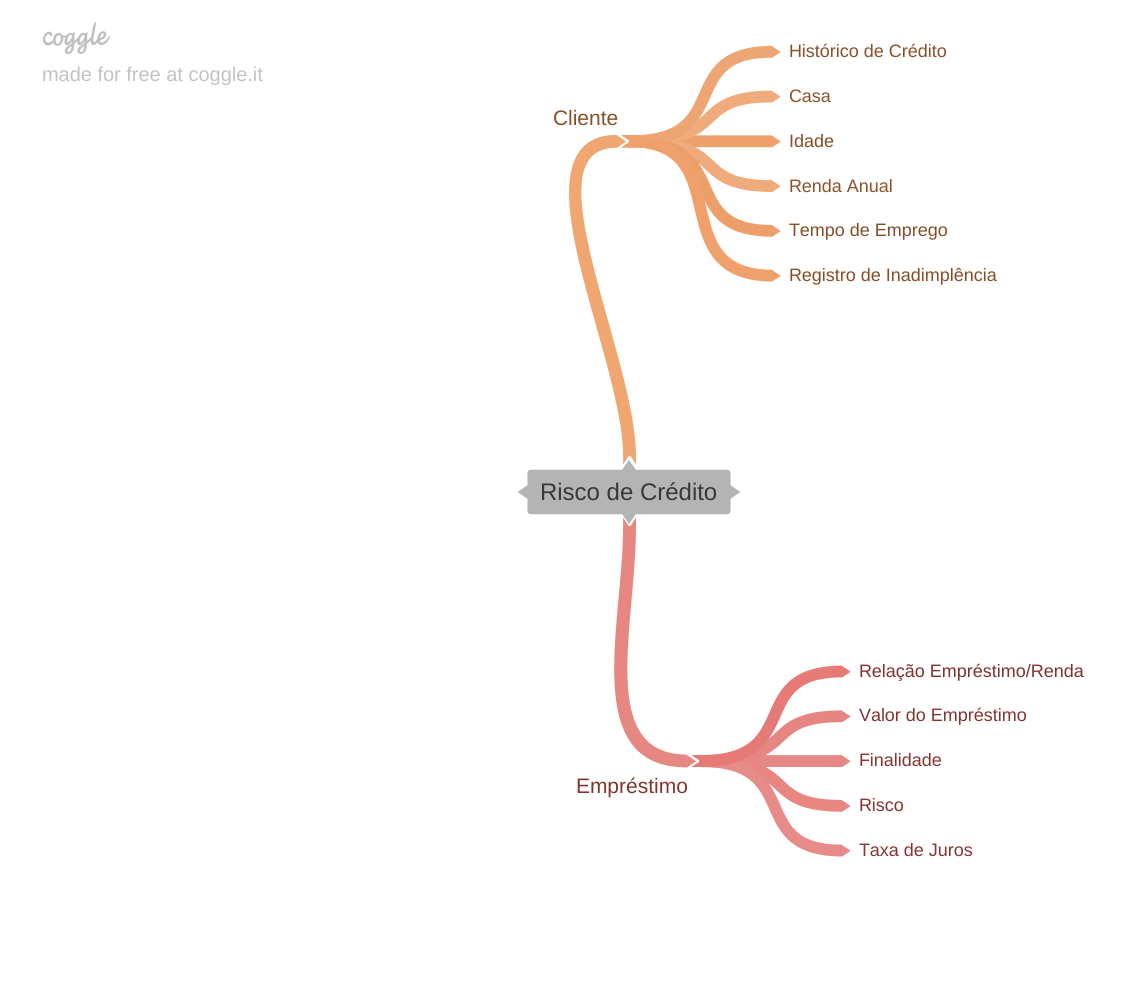

In [427]:
Image( '../mind_map.png' )

### 2.2.1 Hipóteses do Cliente

- Pessoas mais jovens podem ter uma taxa de inadimplência maior devido à falta de experiência financeira e estabilidade profissional.


- Indivíduos com renda mais alta tendem a ter uma menor probabilidade de inadimplência, pois têm mais recursos para cumprir suas obrigações financeiras.


- Pessoas que possuem casa própria podem apresentar uma menor taxa de inadimplência, pois têm um ativo significativo que pode ser usado como garantia.


- Pessoas com um histórico de emprego mais longo podem ter uma menor probabilidade de inadimplência, pois demonstram estabilidade financeira e capacidade de pagamento ao longo do tempo.

- Pessoas com registros anteriores de inadimplência podem ter uma maior probabilidade de inadimplência no futuro, indicando uma tendência de comportamento de risco.

### 2.2.2 Hipóteses do Empréstimo

- A finalidade do empréstimo pode afetar a probabilidade de inadimplência.


- Empréstimos classificados em categorias de maior risco podem ter uma probabilidade maior de inadimplência. 


- Empréstimos de valores mais altos podem apresentar uma maior probabilidade de inadimplência, pois representam um compromisso financeiro maior para o mutuário.


- Taxas de juros mais altas podem aumentar a probabilidade de inadimplência, especialmente para mutuários com renda mais baixa ou histórico de crédito comprometido.


- Uma relação alta entre o valor do empréstimo e a renda da pessoa pode indicar uma capacidade limitada de pagamento e, portanto, uma maior probabilidade de inadimplência.

- Uma taxa ajustada de juros pela renda mais alta está associada a uma maior propabilidade de inadimplência

- Uma alta proporção do valor do empréstimo em relação a idade está associada a uma maior probabilidade de inadimplência

- Uma alta proporção do valor do empréstimo em relação ao tempo de emprego está associada a uma alta probabilidade de inadimplência

- Uma alta proporção do valor do empréstimo em relação ao Histórico de Crédito está associada a uma alta probabilidade de inadimplência

- Uma baixa proporção da renda em relação ao valor do empréstimo está associada a uma probabilidade maior de inadimplência

- Pessoas com renda mais alta têm uma menor probabilidade de inadimplência

- Faixas etárias mais jovens podem estar associadas a uma maior probabilidade de inadimplência

## 2.3 Feature Engineering

In [428]:


# Taxa de Juros Ajustada pela Renda
df2['taxa_juros_ajustada_renda'] = df2['taxa_juros_emprestimo'] / df2['renda']

# Proporção do Valor do Empréstimo em Relação à Idade
df2['proporcao_emprestimo_idade'] = df2['valor_emprestimo'] / df2['idade']

# Proporção do Valor do Empréstimo em Relação ao Tempo de Emprego
df2['tempo_emprego'] = np.where(df2['tempo_emprego'] == 0, 1, df2['tempo_emprego'])
df2['proporcao_emprestimo_tempo_emprego'] = df2['valor_emprestimo'] / df2['tempo_emprego']


# Proporção do Valor do Empréstimo em Relação à História de Crédito
df2['proporcao_emprestimo_historico_credito'] = df2['valor_emprestimo'] / df2['historico_credito']

# Proporção da Renda em Relação ao Valor do Empréstimo
df2['proporcao_renda_emprestimo'] = df2['renda'] / df2['valor_emprestimo']

# Categoria de Renda
faixas_renda = [0, 30000, 60000, 90000, float('inf')]
categorias_renda = ['baixa', 'média baixa', 'média alta', 'alta']
df2['categoria_renda'] = pd.cut(df2['renda'], bins=faixas_renda, labels=categorias_renda)

# Categoria de Idade
faixas_idade = [0, 30, 50, float('inf')]
categorias_idade = ['jovem', 'adulto', 'idoso']
df2['categoria_idade'] = pd.cut(df2['idade'], bins=faixas_idade, labels=categorias_idade)


In [429]:
df2.isna().sum()

idade                                     0
renda                                     0
tempo_emprego                             0
valor_emprestimo                          0
taxa_juros_emprestimo                     0
status_emprestimo                         0
relacao_emprestimo_renda                  0
historico_credito                         0
posse_casa                                0
finalidade_emprestimo                     0
grau_risco_emprestimo                     0
registro_inadimplencia                    0
taxa_juros_ajustada_renda                 0
proporcao_emprestimo_idade                0
proporcao_emprestimo_tempo_emprego        0
proporcao_emprestimo_historico_credito    0
proporcao_renda_emprestimo                0
categoria_renda                           0
categoria_idade                           0
dtype: int64

# 3.0 Filtragem de Variáveis

In [430]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas

In [431]:
df3.head()

,idade,renda,tempo_emprego,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,historico_credito,posse_casa,finalidade_emprestimo,grau_risco_emprestimo,registro_inadimplencia,taxa_juros_ajustada_renda,proporcao_emprestimo_idade,proporcao_emprestimo_tempo_emprego,proporcao_emprestimo_historico_credito,proporcao_renda_emprestimo,categoria_renda,categoria_idade
0,22.0,59000.0,123.0,35000.0,16.02,1.0,0.59,3.0,RENT,PERSONAL,D,Y,0.000272,1590.909091,284.552846,11666.666667,1.685714,média baixa,jovem
1,21.0,9600.0,5.0,1000.0,11.14,0.0,0.10,2.0,OWN,EDUCATION,B,N,0.001160,47.619048,200.000000,500.000000,9.600000,baixa,jovem
2,25.0,9600.0,1.0,5500.0,12.87,1.0,0.57,3.0,MORTGAGE,MEDICAL,C,N,0.001341,220.000000,5500.000000,1833.333333,1.745455,baixa,jovem
3,23.0,65500.0,4.0,35000.0,15.23,1.0,0.53,2.0,RENT,MEDICAL,C,N,0.000233,1521.739130,8750.000000,17500.000000,1.871429,média alta,jovem
4,24.0,54400.0,8.0,35000.0,14.27,1.0,0.55,4.0,RENT,MEDICAL,C,Y,0.000262,1458.333333,4375.000000,8750.000000,1.554286,média baixa,jovem


## 3.2 Filtragem de Colunas

# 4.0 Análise Exploratória de Dados

In [432]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

<Axes: xlabel='count', ylabel='status_emprestimo'>

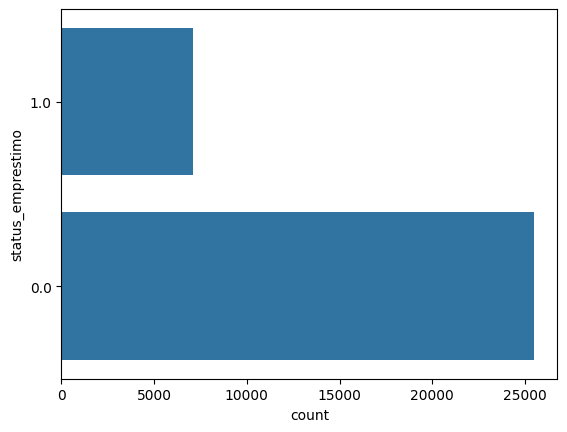

In [433]:
aux = df4.copy()
aux['status_emprestimo'] = aux['status_emprestimo'].astype(str)
sns.countplot(aux['status_emprestimo'])

### 4.1.2 Variáveis Numéricas

In [434]:
num_attributes2 = df4.select_dtypes(exclude=['category', 'object'])

In [435]:
# num_attributes2.hist( bins=25 );

### 4.1.3 Variáveis Categóricas

## 4.2 Análise Bivariada

#### 4.2.1 Hipóteses do Cliente

##### Pessoas mais jovens podem ter uma taxa de inadimplência maior devido à falta de experiência financeira e estabilidade profissional.

<Axes: xlabel='idade', ylabel='Count'>

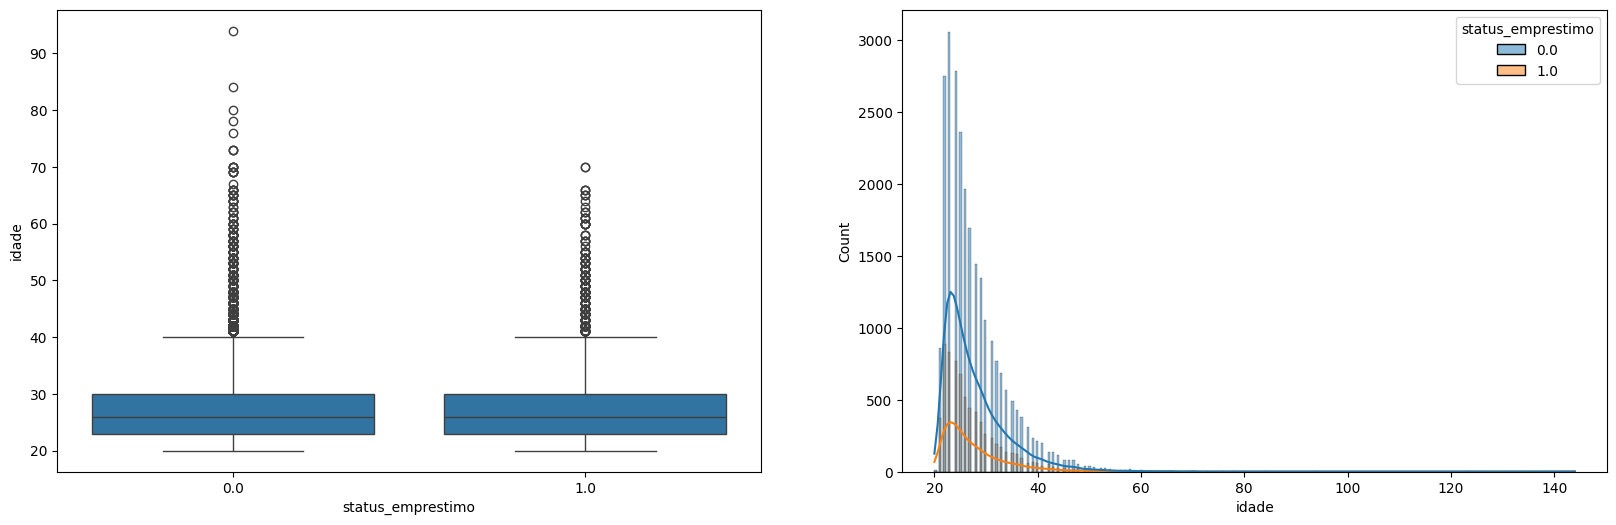

In [436]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='idade', data=df4.loc[df4['idade'] < 100])

plt.subplot(1,2,2)
sns.histplot(data=df4, x='idade', hue='status_emprestimo', kde=True)

##### Indivíduos com renda mais alta tendem a ter uma menor probabilidade de inadimplência, pois têm mais recursos para cumprir suas obrigações financeiras.

C:\Users\thale\AppData\Local\Temp\ipykernel_6940\2621765011.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = aux[['categoria_renda', 'status_emprestimo']].groupby('categoria_renda').count().reset_index()


<Axes: xlabel='categoria_renda', ylabel='status_emprestimo'>

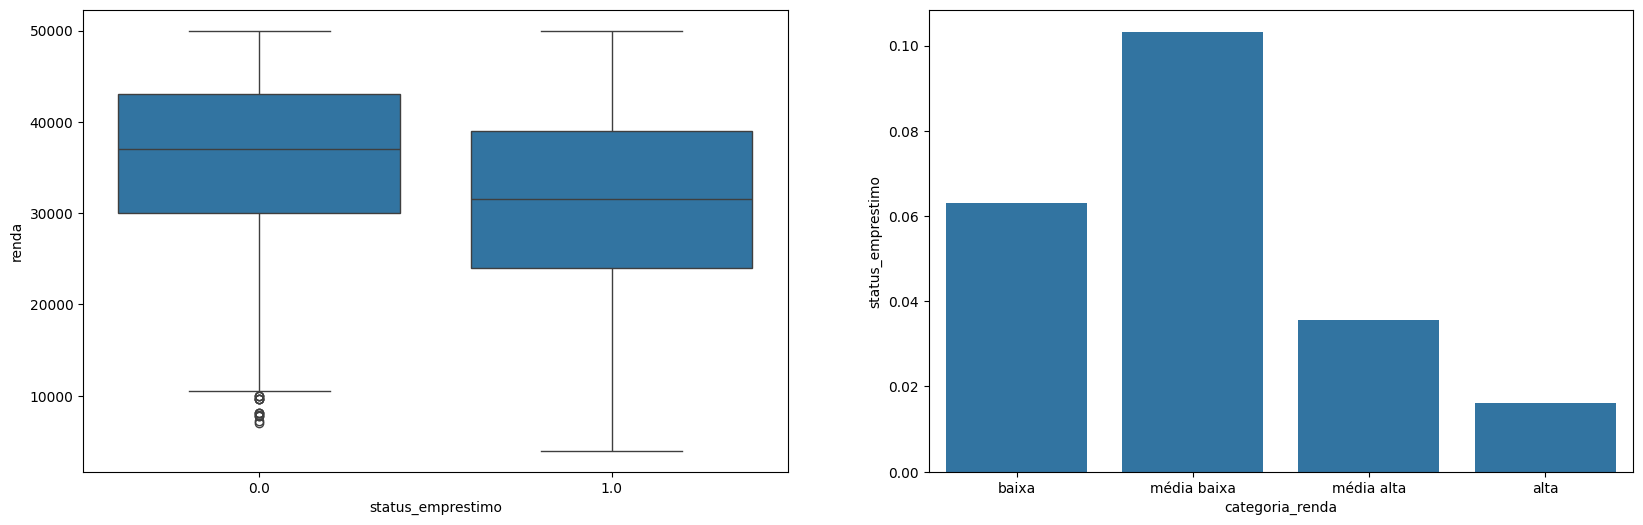

In [437]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='renda', data=df4.loc[df4['renda'] <50000])

plt.subplot(1,2,2)
aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['categoria_renda', 'status_emprestimo']].groupby('categoria_renda').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='categoria_renda', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

##### Pessoas que possuem casa própria podem apresentar uma menor taxa de inadimplência, pois têm um ativo significativo que pode ser usado como garantia.

<Axes: xlabel='posse_casa', ylabel='status_emprestimo'>

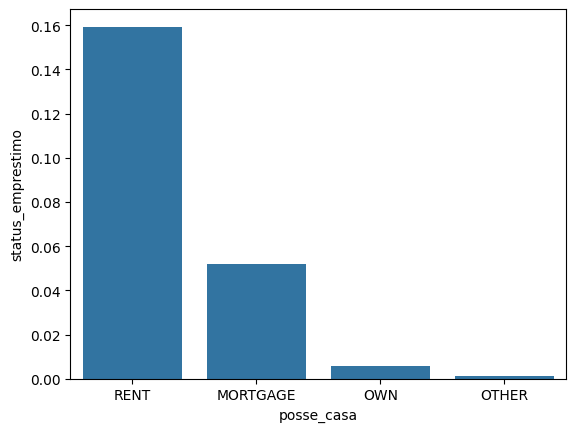

In [438]:
aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['posse_casa', 'status_emprestimo']].groupby('posse_casa').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='posse_casa', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

##### Pessoas com um histórico de emprego mais longo podem ter uma menor probabilidade de inadimplência, pois demonstram estabilidade financeira e capacidade de pagamento ao longo do tempo.


<Axes: xlabel='status_emprestimo', ylabel='tempo_emprego'>

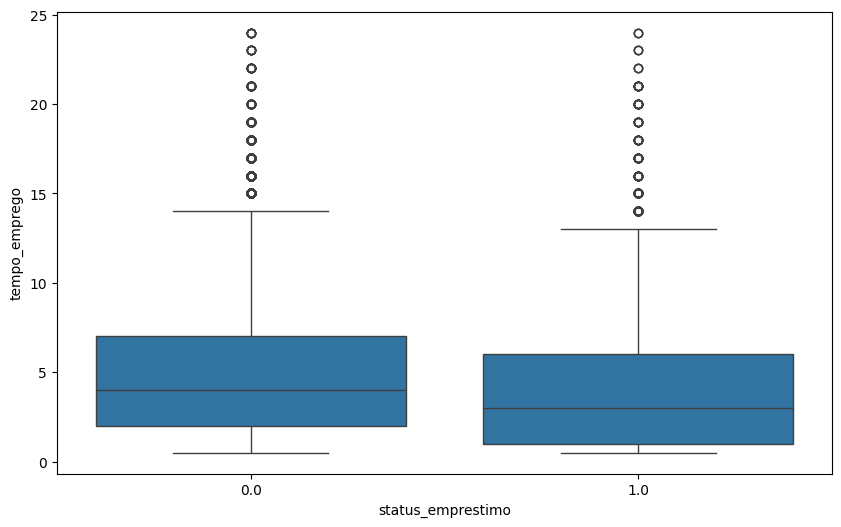

In [439]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4.loc[df4['tempo_emprego'] < 25], x='status_emprestimo', y='tempo_emprego')

##### Pessoas com registros anteriores de inadimplência podem ter uma maior probabilidade de inadimplência no futuro, indicando uma tendência de comportamento de risco.

<Axes: xlabel='registro_inadimplencia', ylabel='status_emprestimo'>

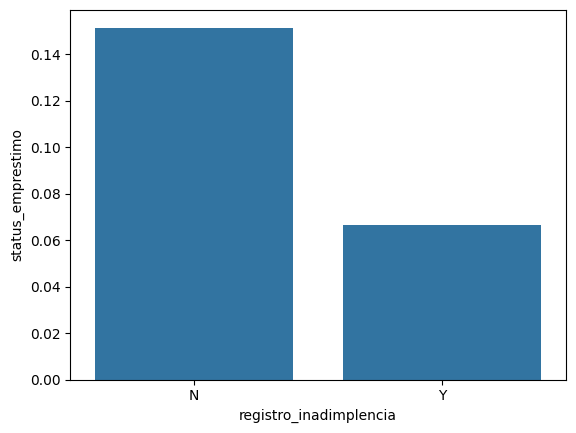

In [440]:
aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['registro_inadimplencia', 'status_emprestimo']].groupby('registro_inadimplencia').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='registro_inadimplencia', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

#### 4.2.2 Hipóteses do Empréstimo

##### A finalidade do empréstimo pode afetar a probabilidade de inadimplência.

<Axes: xlabel='finalidade_emprestimo', ylabel='status_emprestimo'>

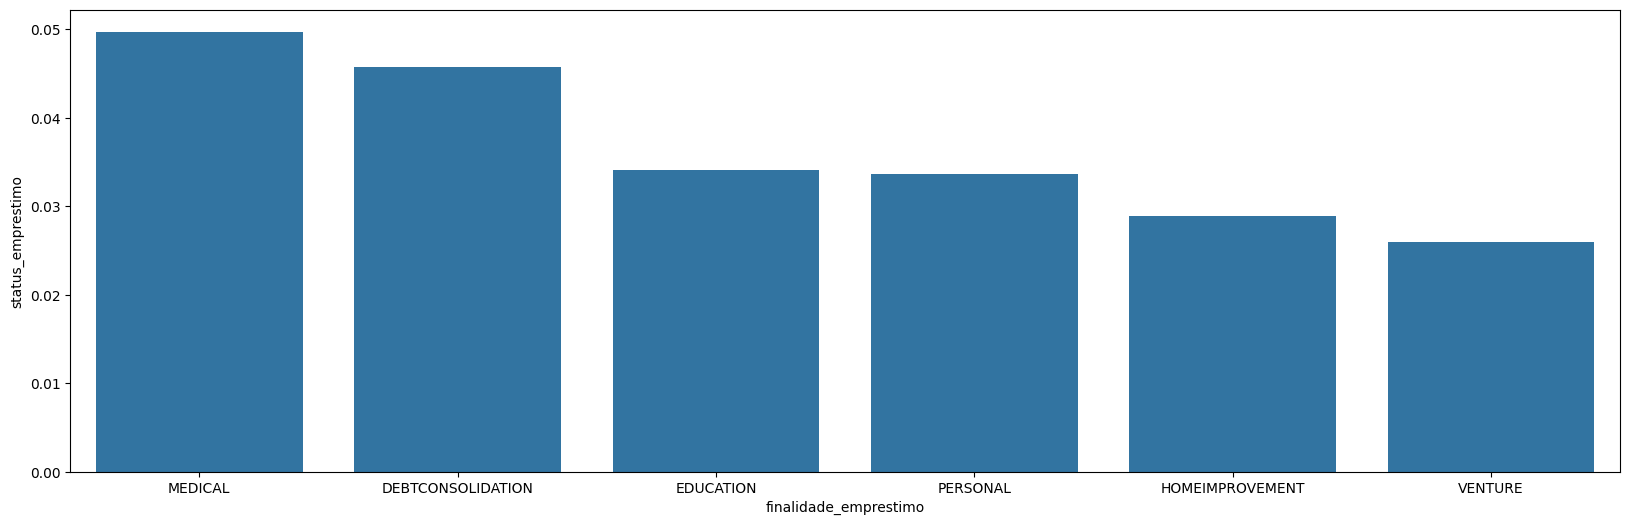

In [441]:
plt.figure(figsize=(20, 6))

aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['finalidade_emprestimo', 'status_emprestimo']].groupby('finalidade_emprestimo').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='finalidade_emprestimo', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

##### Empréstimos classificados em categorias de maior risco podem ter uma probabilidade maior de inadimplência. 

<Axes: xlabel='grau_risco_emprestimo', ylabel='status_emprestimo'>

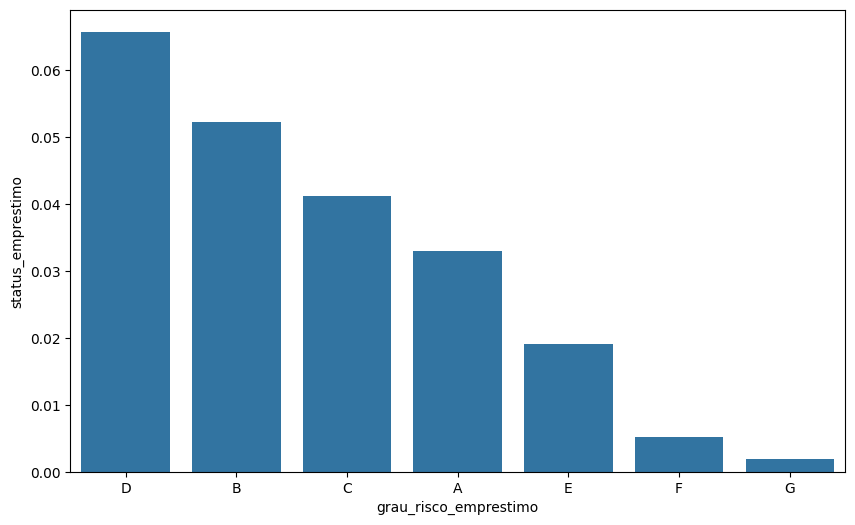

In [442]:
plt.figure(figsize=(10, 6))
aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['grau_risco_emprestimo', 'status_emprestimo']].groupby('grau_risco_emprestimo').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='grau_risco_emprestimo', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

##### Empréstimos de valores mais altos podem apresentar uma maior probabilidade de inadimplência, pois representam um compromisso financeiro maior para o mutuário.

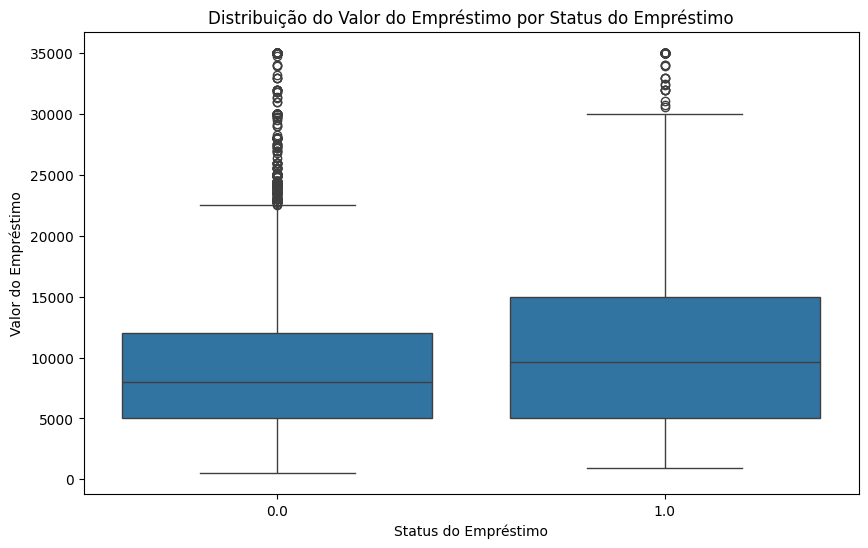

In [443]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='status_emprestimo', y='valor_emprestimo')
plt.title('Distribuição do Valor do Empréstimo por Status do Empréstimo')
plt.xlabel('Status do Empréstimo')
plt.ylabel('Valor do Empréstimo')
plt.show()

##### Taxas de juros mais altas podem aumentar a probabilidade de inadimplência, especialmente para mutuários com renda mais baixa ou histórico de crédito comprometido.

<Axes: xlabel='status_emprestimo', ylabel='taxa_juros_emprestimo'>

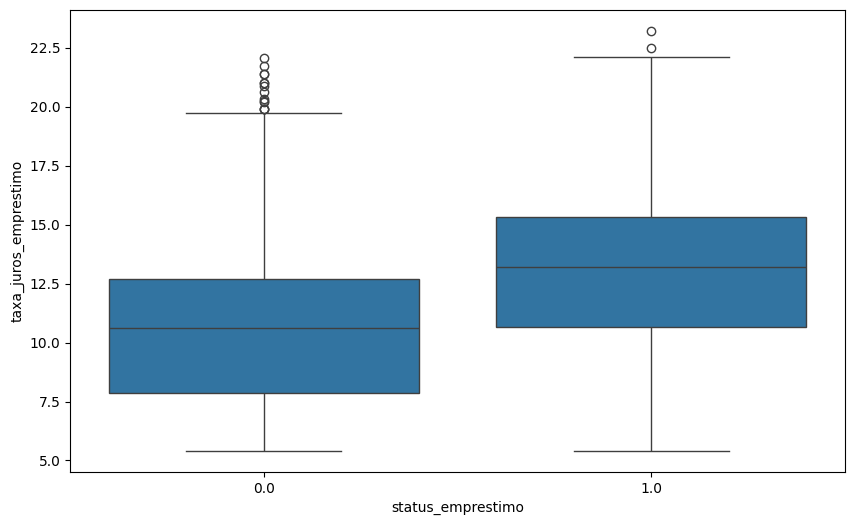

In [444]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='status_emprestimo', y='taxa_juros_emprestimo')


##### Uma relação alta entre o valor do empréstimo e a renda da pessoa pode indicar uma capacidade limitada de pagamento e, portanto, uma maior probabilidade de inadimplência.


<Axes: xlabel='status_emprestimo', ylabel='relacao_emprestimo_renda'>

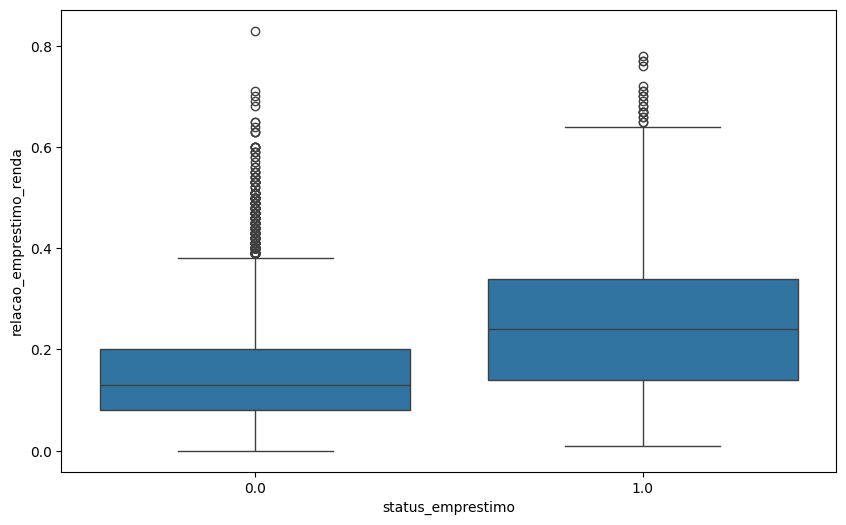

In [445]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='status_emprestimo', y='relacao_emprestimo_renda')

##### Uma taxa ajustada de juros pela renda mais alta está associada a uma maior propabilidade de inadimplência

Text(0, 0.5, 'Contagem')

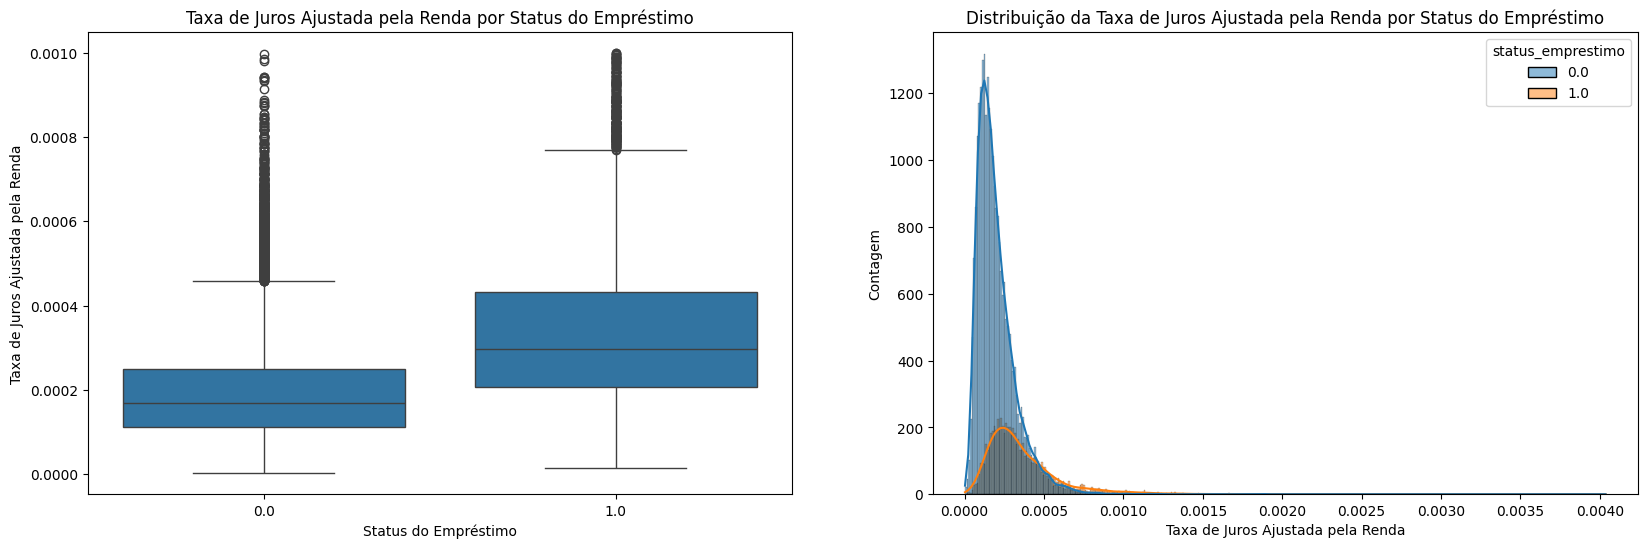

In [446]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 6))
plt.subplot( 1, 2, 1 )
sns.boxplot(x='status_emprestimo', y='taxa_juros_ajustada_renda', data=df4.loc[df4['taxa_juros_ajustada_renda'] < 0.0010])
plt.title('Taxa de Juros Ajustada pela Renda por Status do Empréstimo')
plt.xlabel('Status do Empréstimo')
plt.ylabel('Taxa de Juros Ajustada pela Renda')



plt.subplot( 1, 2, 2 )
sns.histplot(data=df4, x='taxa_juros_ajustada_renda', hue='status_emprestimo', kde=True)
plt.title('Distribuição da Taxa de Juros Ajustada pela Renda por Status do Empréstimo')
plt.xlabel('Taxa de Juros Ajustada pela Renda')
plt.ylabel('Contagem')



##### Uma alta proporção do valor do empréstimo em relação a idade está associada a uma maior probabilidade de inadimplência

Text(0, 0.5, 'Contagem')

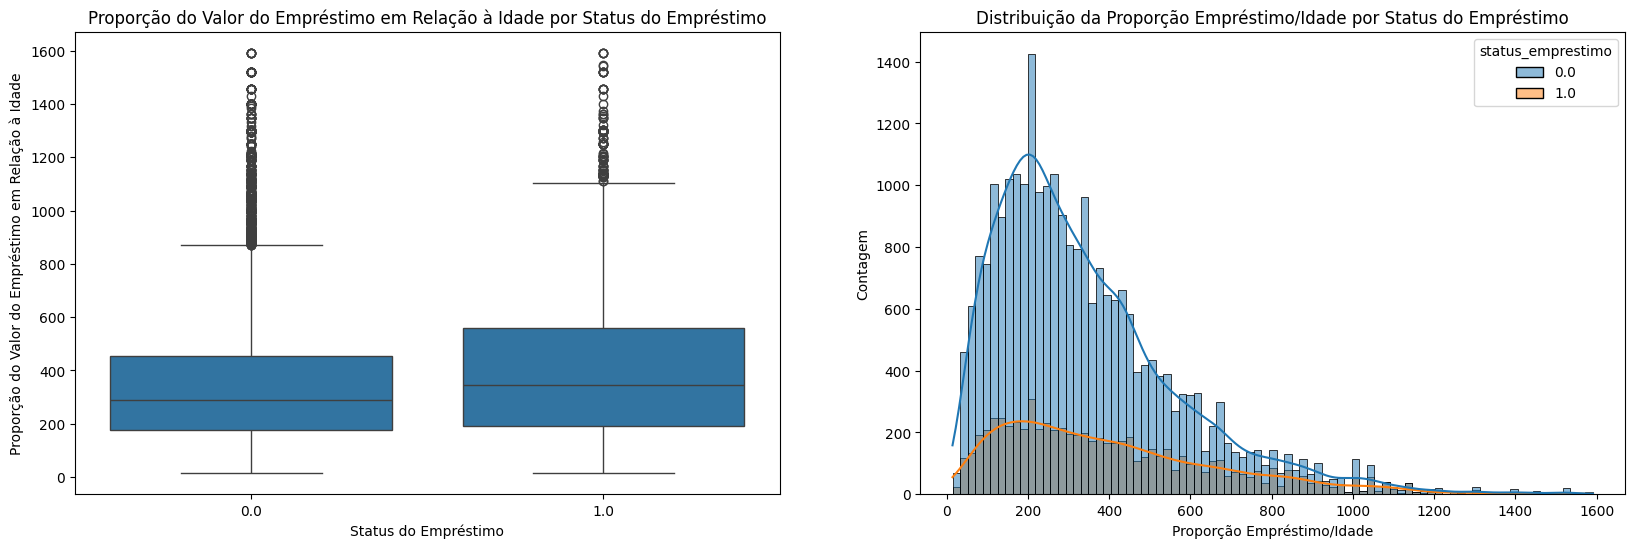

In [447]:
plt.figure(figsize=(20, 6))
plt.subplot( 1, 2, 1 )
sns.boxplot(x='status_emprestimo', y='proporcao_emprestimo_idade', data=df4)
plt.title('Proporção do Valor do Empréstimo em Relação à Idade por Status do Empréstimo')
plt.xlabel('Status do Empréstimo')
plt.ylabel('Proporção do Valor do Empréstimo em Relação à Idade')


plt.subplot( 1, 2, 2 )
sns.histplot(data=df4, x='proporcao_emprestimo_idade', hue='status_emprestimo', kde=True)
plt.title('Distribuição da Proporção Empréstimo/Idade por Status do Empréstimo')
plt.xlabel('Proporção Empréstimo/Idade')
plt.ylabel('Contagem')

##### Uma alta proporção do valor do empréstimo em relação ao tempo de emprego está associada a uma alta probabilidade de inadimplência

<Axes: xlabel='proporcao_emprestimo_tempo_emprego', ylabel='Count'>

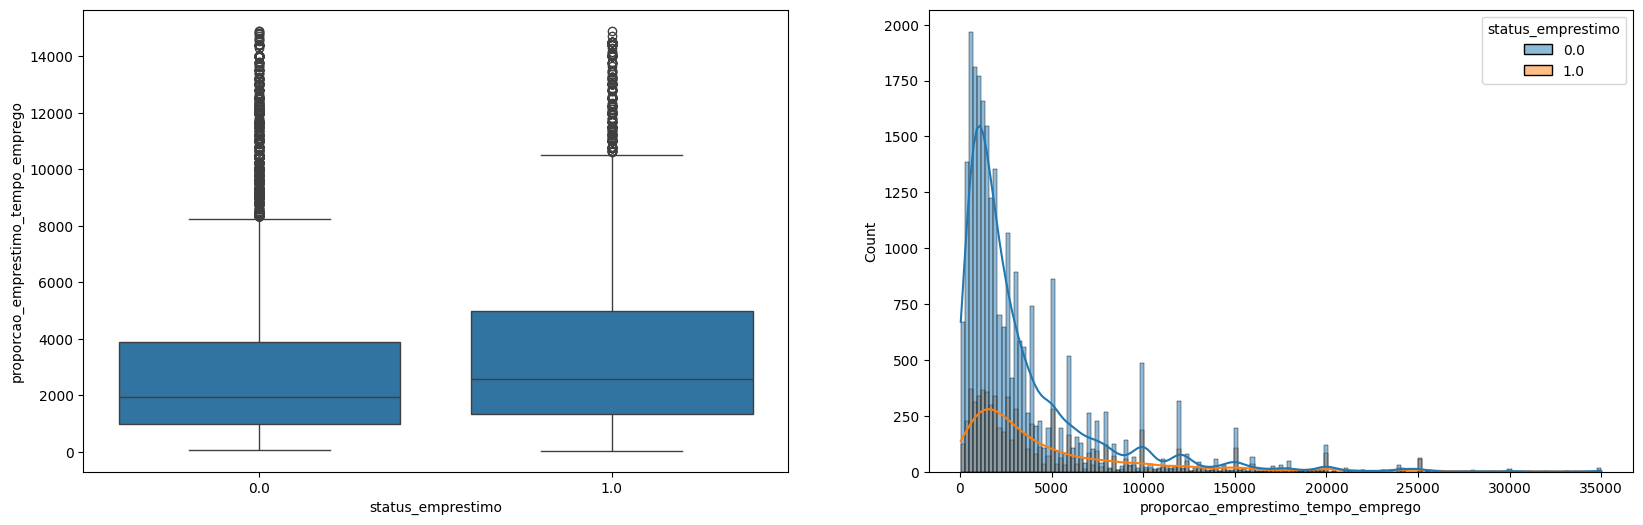

In [448]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='proporcao_emprestimo_tempo_emprego', data=df4.loc[df4['proporcao_emprestimo_tempo_emprego'] < 15000])

plt.subplot(1,2,2)
sns.histplot(data=df4, x='proporcao_emprestimo_tempo_emprego', hue='status_emprestimo', kde=True)

##### Uma alta proporção do valor do empréstimo em relação ao Histórico de Crédito está associada a uma alta probabilidade de inadimplência

<Axes: xlabel='proporcao_emprestimo_historico_credito', ylabel='Count'>

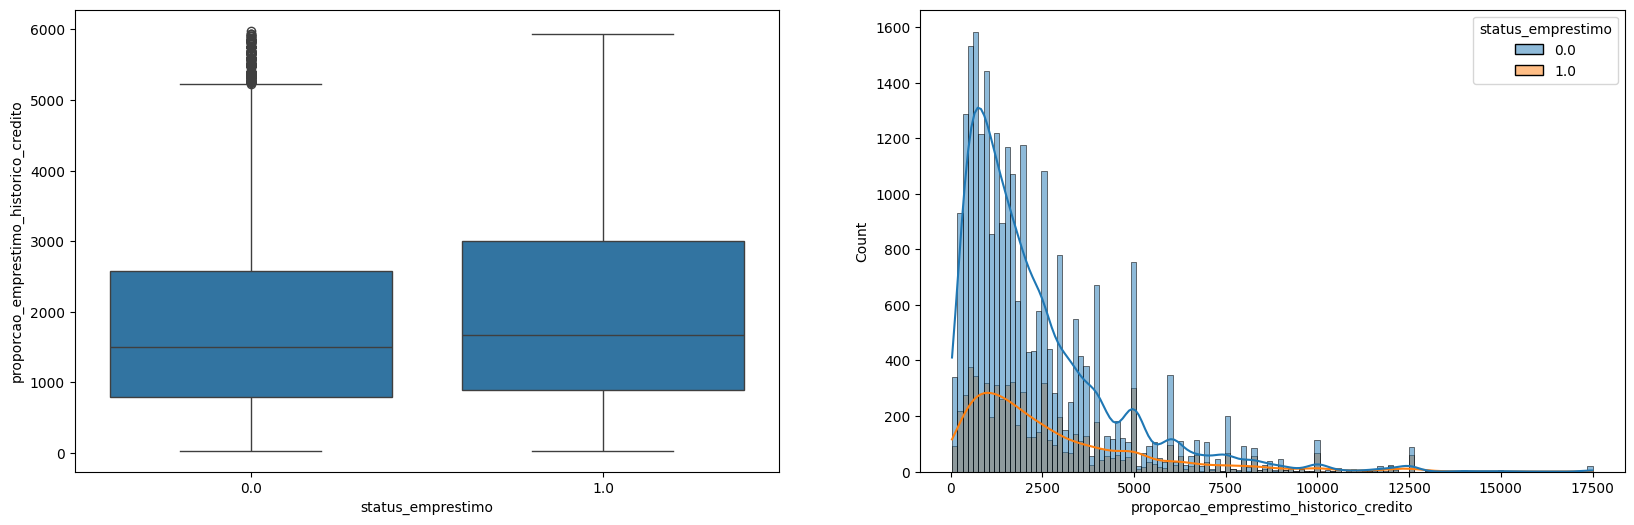

In [449]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='proporcao_emprestimo_historico_credito', data=df4.loc[df4['proporcao_emprestimo_historico_credito'] < 6000])

plt.subplot(1,2,2)
sns.histplot(data=df4, x='proporcao_emprestimo_historico_credito', hue='status_emprestimo', kde=True)

##### Uma baixa proporção da renda em relação ao valor do empréstimo está associada a uma probabilidade maior de inadimplência

<Axes: xlabel='proporcao_renda_emprestimo', ylabel='Count'>

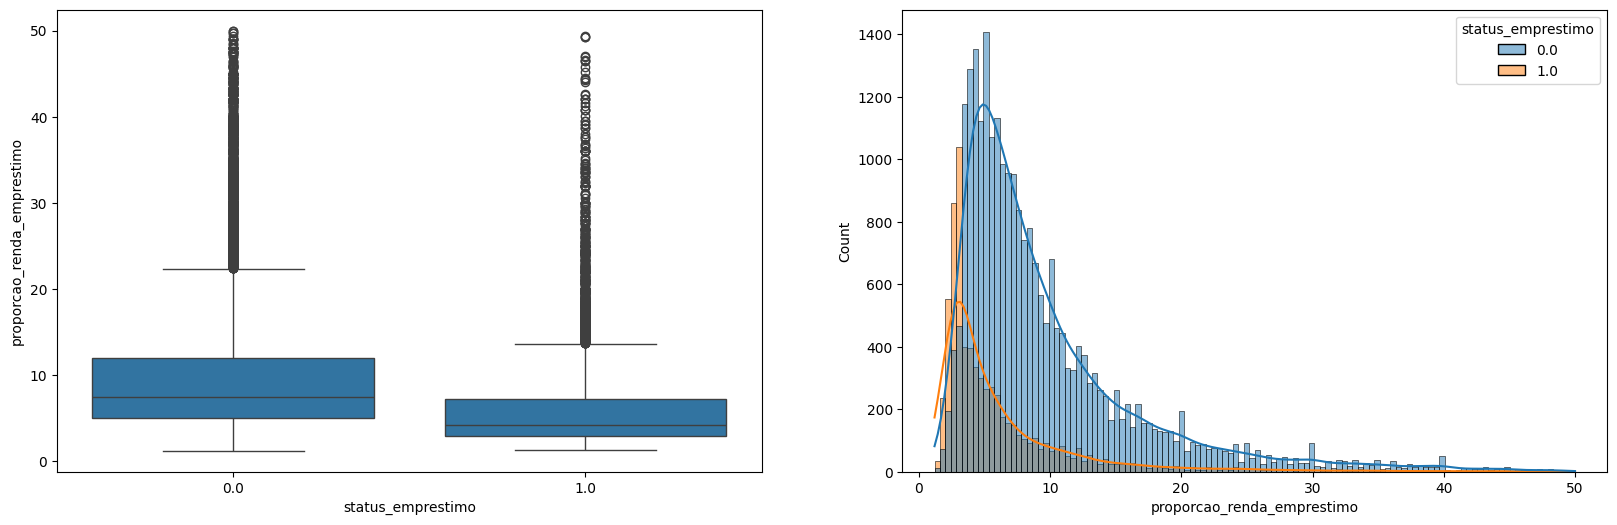

In [450]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='proporcao_renda_emprestimo', data=df4.loc[df4['proporcao_renda_emprestimo'] < 50])

plt.subplot(1,2,2)
sns.histplot(data=df4.loc[df4['proporcao_renda_emprestimo'] < 50], x='proporcao_renda_emprestimo', hue='status_emprestimo', kde=True)



##### Pessoas com renda mais alta têm uma menor probabilidade de inadimplência

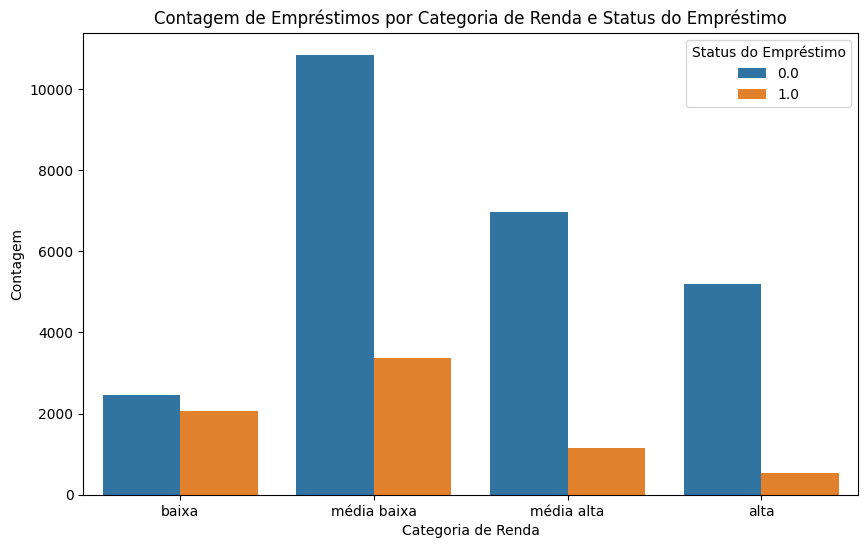

In [451]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df4, x='categoria_renda', hue='status_emprestimo')
plt.title('Contagem de Empréstimos por Categoria de Renda e Status do Empréstimo')
plt.xlabel('Categoria de Renda')
plt.ylabel('Contagem')
plt.legend(title='Status do Empréstimo')
plt.show()

##### Faixas etárias mais jovens podem estar associadas a uma maior probabilidade de inadimplência

C:\Users\thale\AppData\Local\Temp\ipykernel_6940\4272906175.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df4.groupby(['categoria_idade', 'status_emprestimo']).size().unstack().plot(kind='pie', subplots=True, figsize=(15, 8), autopct='%1.1f%%')


<Figure size 1000x600 with 0 Axes>

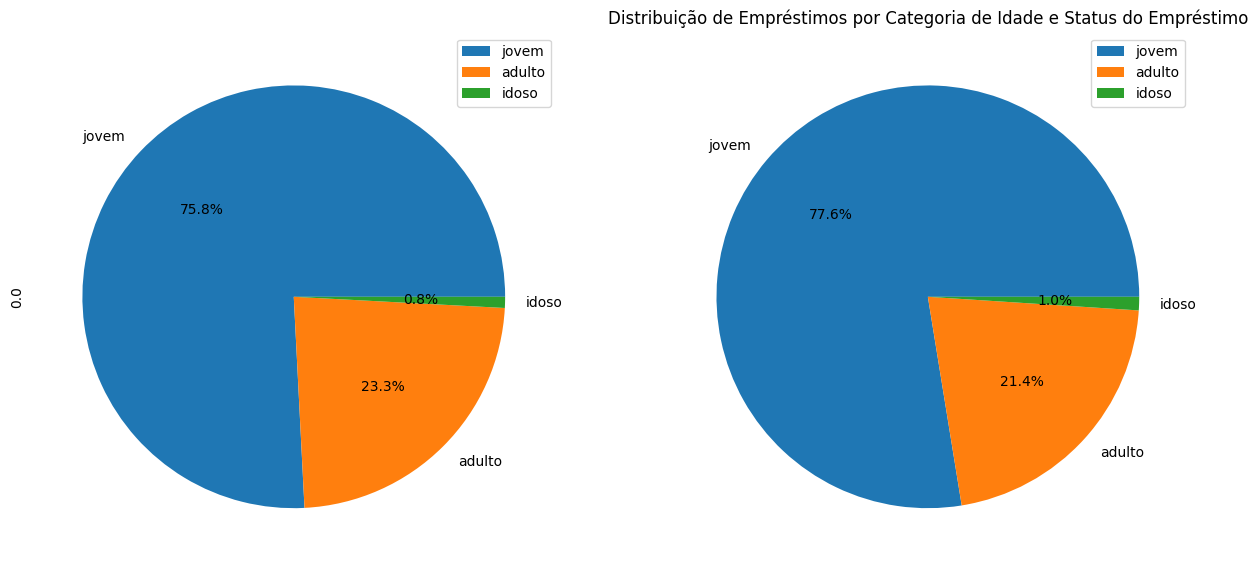

In [452]:
plt.figure(figsize=(10, 6))
df4.groupby(['categoria_idade', 'status_emprestimo']).size().unstack().plot(kind='pie', subplots=True, figsize=(15, 8), autopct='%1.1f%%')
plt.title('Distribuição de Empréstimos por Categoria de Idade e Status do Empréstimo')
plt.ylabel('')
plt.show()

## 4.3 Análise Multivariada

### 4.3.1 Atributos Numéricos

In [453]:
num_attributes3 = df4.select_dtypes(exclude=['object','category'])

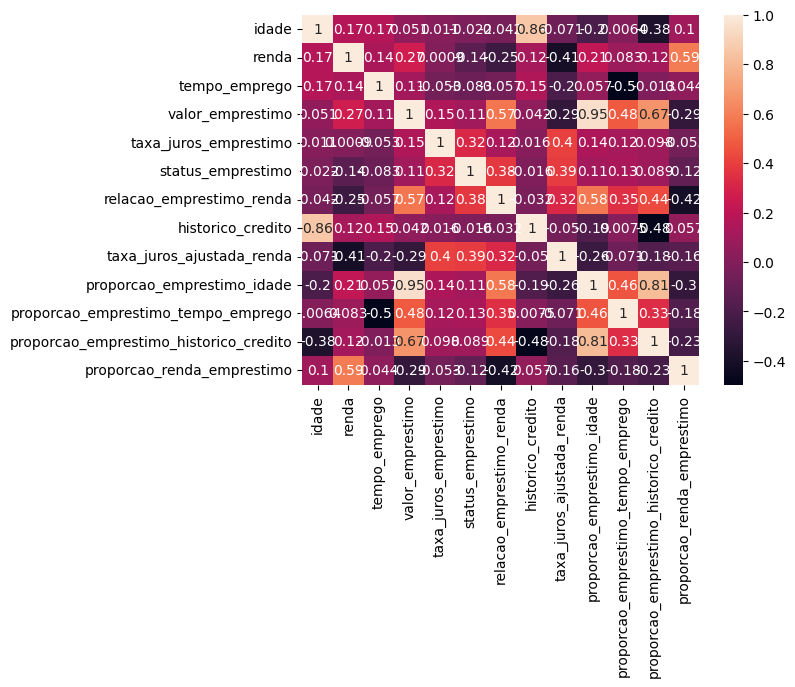

In [454]:
correlation = num_attributes3.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Atributos Categóricos

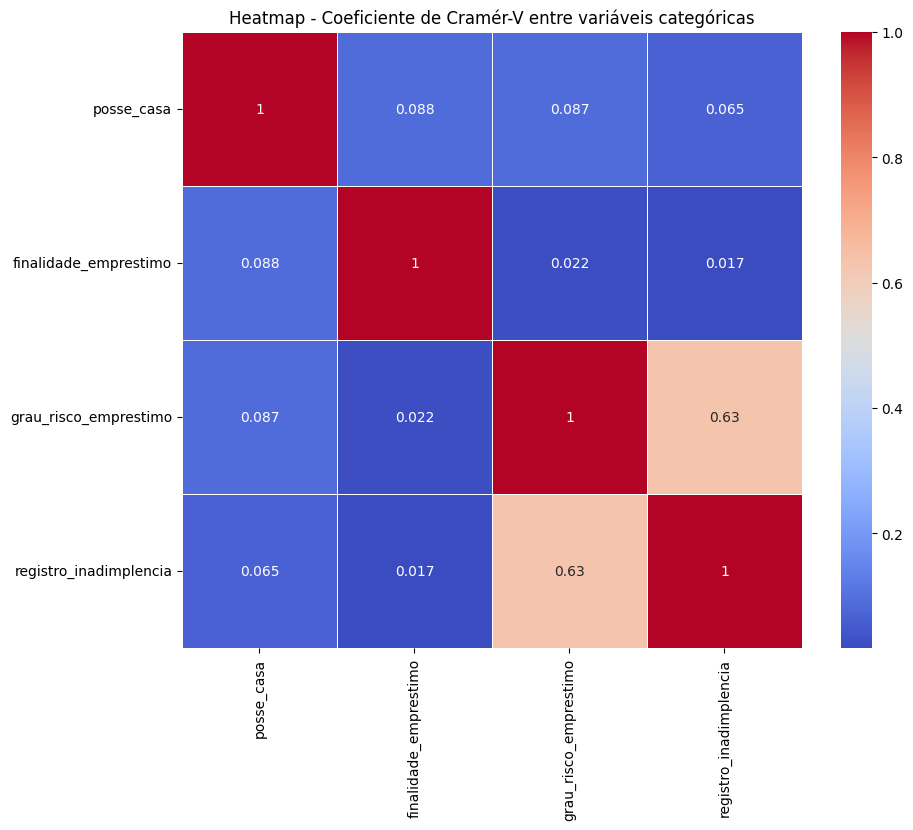

In [455]:
a = df4.select_dtypes( include=['object', 'category'] )

# Selecionar apenas colunas categóricas
categorical_columns = df4.select_dtypes(include='object').columns

# Criar uma matriz para armazenar os valores de Cramér-V
cramer_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calcular o coeficiente de Cramér-V para todas as combinações de colunas categóricas
for col1 in categorical_columns:
    for col2 in categorical_columns:
        cramer_v_matrix.loc[col1, col2] = cramer_v(df4[col1], df4[col2])

# Plotar um heatmap dos valores de Cramér-V
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_v_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap - Coeficiente de Cramér-V entre variáveis categóricas')
plt.show()

# 5.0 Data Preparation

In [456]:
df5 = df4.copy()

In [457]:
df5.isna().sum()

idade                                     0
renda                                     0
tempo_emprego                             0
valor_emprestimo                          0
taxa_juros_emprestimo                     0
status_emprestimo                         0
relacao_emprestimo_renda                  0
historico_credito                         0
posse_casa                                0
finalidade_emprestimo                     0
grau_risco_emprestimo                     0
registro_inadimplencia                    0
taxa_juros_ajustada_renda                 0
proporcao_emprestimo_idade                0
proporcao_emprestimo_tempo_emprego        0
proporcao_emprestimo_historico_credito    0
proporcao_renda_emprestimo                0
categoria_renda                           0
categoria_idade                           0
dtype: int64

In [458]:
df5['proporcao_emprestimo_tempo_emprego'].min()

47.61904761904762

In [459]:
df5.loc[df5.index == 16]

,idade,renda,tempo_emprego,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,historico_credito,posse_casa,finalidade_emprestimo,grau_risco_emprestimo,registro_inadimplencia,taxa_juros_ajustada_renda,proporcao_emprestimo_idade,proporcao_emprestimo_tempo_emprego,proporcao_emprestimo_historico_credito,proporcao_renda_emprestimo,categoria_renda,categoria_idade
16,23.0,120000.0,1.0,35000.0,7.9,0.0,0.29,4.0,RENT,EDUCATION,A,N,0.000066,1521.73913,35000.0,8750.0,3.428571,alta,jovem


In [460]:
# min_val = df5[column_name].min()
# max_val = data[column_name].max()
# data[column_name] = (data[column_name] - min_val) / (max_val - min_val)

# #return data

In [461]:
# df5.loc[df5['proporcao_emprestimo_tempo_emprego'].isna()]

## 5.1 Variáveis Numéricas

In [462]:
num_columns = num_attributes3.columns

for i in num_columns:
    df5 = rescale_column(df5, i)

In [463]:
df5.isna().sum()

idade                                     0
renda                                     0
tempo_emprego                             0
valor_emprestimo                          0
taxa_juros_emprestimo                     0
status_emprestimo                         0
relacao_emprestimo_renda                  0
historico_credito                         0
posse_casa                                0
finalidade_emprestimo                     0
grau_risco_emprestimo                     0
registro_inadimplencia                    0
taxa_juros_ajustada_renda                 0
proporcao_emprestimo_idade                0
proporcao_emprestimo_tempo_emprego        0
proporcao_emprestimo_historico_credito    0
proporcao_renda_emprestimo                0
categoria_renda                           0
categoria_idade                           0
dtype: int64

## 5.2 Variáveis Categóricas

In [464]:
cat_att = df5.select_dtypes(include=['object', 'category'])

In [465]:
for i in cat_att.columns:
    df5 = label_encoding(df5, i)

# 6.0 Seleção de atributos

In [466]:
df6 = df5.copy()

In [467]:
df6.head()

,idade,renda,tempo_emprego,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,historico_credito,posse_casa,finalidade_emprestimo,grau_risco_emprestimo,registro_inadimplencia,taxa_juros_ajustada_renda,proporcao_emprestimo_idade,proporcao_emprestimo_tempo_emprego,proporcao_emprestimo_historico_credito,proporcao_renda_emprestimo,categoria_renda,categoria_idade
0,0.016129,0.009173,1.000000,1.000000,0.595506,1.0,0.710843,0.035714,3,4,3,1,0.066790,1.000000,0.006779,0.666009,0.000380,3,2
1,0.008065,0.000934,0.036735,0.014493,0.321348,0.0,0.120482,0.000000,2,1,1,0,0.287162,0.021142,0.004360,0.026654,0.006634,1,2
2,0.040323,0.000934,0.004082,0.144928,0.418539,1.0,0.686747,0.035714,0,3,2,0,0.331839,0.130478,0.155995,0.102994,0.000427,1,2
3,0.024194,0.010257,0.028571,1.000000,0.551124,1.0,0.638554,0.000000,3,3,2,0,0.057120,0.956128,0.248978,1.000000,0.000527,2,2
4,0.032258,0.008406,0.061224,1.000000,0.497191,1.0,0.662651,0.071429,3,3,2,1,0.064507,0.915912,0.123808,0.499013,0.000276,3,2


## 6.1 Feature Importance - Árvore

In [468]:
# X = df6.drop(columns=['status_emprestimo'])
# y = df6['status_emprestimo']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=42)

In [469]:
# model = RandomForestClassifier()

# # # Treinar o modelo
# model.fit(X_train, y_train)

# # # Obter a importância das features
# importances = model.feature_importances_

In [470]:
# feature_names = X_train.columns  # Supondo que X seja um DataFrame do Pandas

# # # Ordenar as importâncias e os nomes das features juntos
# sorted_indices = np.argsort(importances)[::-1]
# sorted_importances = importances[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# # # Criar um gráfico de barras
# # plt.figure(figsize=(10, 6))
# # plt.bar(range(len(sorted_importances)), sorted_importances, color='b', align='center')

# # # Adicionar nome das features no eixo x
# # plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
# # plt.xlabel('Feature')
# # plt.ylabel('Importance')

# # # Adicionar título ao gráfico
# # plt.title('Feature Importance')

# # # Mostrar o gráfico
# # plt.tight_layout()
# # plt.show()

In [471]:
# # Ordenar as importâncias e os nomes das features juntos
# sorted_indices = np.argsort(importances)[::-1]
# sorted_importances = importances[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# # Realizar a análise de cotovelo
# num_features = len(importances)
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, num_features + 1), np.cumsum(sorted_importances), marker='o', linestyle='-')
# plt.xlabel('Número de Features Selecionadas')
# plt.ylabel('Variância Explicada Acumulada')
# plt.title('Análise de Cotovelo')
# plt.grid(True)
# plt.show()


In [472]:
# chosen_features = sorted_feature_names[:15]

In [473]:
chosen_features = ['proporcao_renda_emprestimo', 'relacao_emprestimo_renda',
       'grau_risco_emprestimo', 'posse_casa', 'taxa_juros_ajustada_renda',
       'renda', 'taxa_juros_emprestimo', 'finalidade_emprestimo',
       'proporcao_emprestimo_tempo_emprego', 'proporcao_emprestimo_idade',
       'tempo_emprego', 'proporcao_emprestimo_historico_credito',
       'valor_emprestimo', 'idade', 'historico_credito']

## 6.2 Regularização das Regressões

### 6.2.1 Lasso

In [145]:
# from sklearn.linear_model import Lasso, Ridge
# from sklearn.feature_selection import SelectFromModel

In [146]:
# lasso_model = Lasso(alpha=0.005, random_state=42)
# lasso_model.fit(X_train, y_train)

# # Usar SelectFromModel para selecionar features com base nas importâncias do Lasso
# select_model = SelectFromModel(lasso_model)
# select_model.fit(X_train, y_train)

# # Obter as features selecionadas
# selected_features = X_train.columns[select_model.get_support()]

# # Imprimir as features selecionadas
# print(selected_features)

In [147]:
# chosen_features = selected_features

### 6.2.2 Ridge

In [148]:
# ridge_model = Ridge(alpha=0.005, random_state=42)
# ridge_model.fit(X_train, y_train)

# # Usar SelectFromModel para selecionar features com base nas importâncias do Lasso
# select_model = SelectFromModel(ridge_model)
# select_model.fit(X_train, y_train)

# # Obter as features selecionadas
# selected_features = X_train.columns[select_model.get_support()]

# # Imprimir as features selecionadas
# print(selected_features)

In [149]:
# chosen_features = selected_features

## 6.3 BORUTA

In [150]:
# from boruta import BorutaPy
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np
  
# # Suponha que X_train e y_train sejam seus conjuntos de treinamento

# # Inicialize o modelo RandomForestClassifier
# rf = RandomForestClassifier(n_jobs=-1)

# # Inicialize o BorutaPy corrigindo o uso de np.int
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train.values, y_train.values.ravel())


In [151]:
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

In [152]:
# cols_selected_boruta

In [153]:
# chosen_features = cols_selected_boruta

# 7.0 Machine Learning Model

In [475]:
df7 = df6.copy()

In [476]:
X = df7[chosen_features] #df7.drop('status_emprestimo', axis=1)
y = df7['status_emprestimo']

In [477]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)



# # Definição do Fold
# num_folds = 30
# scores = ['precision', 'recall']
# kfold = KFold(num_folds, shuffle=True, random_state=42)

In [478]:
def cross_validation_kfold(model, X, y):
    num_folds = 30
    scores = ['precision', 'recall']
    kfold = KFold(num_folds, shuffle=True, random_state=42)

    scores_result = cross_validate(model, X, y, scoring=scores, cv=kfold)
    model_name = model.__class__.__name__
    precision_mean = scores_result['test_precision'].mean()
    recall_mean = scores_result['test_recall'].mean()

    result_dict = {'model': model_name, 'precision': precision_mean, 'recall': recall_mean}
    result_df = pd.DataFrame([result_dict])

    return result_df

## 7.1 Random Forest

In [158]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
yhat = rf.predict(X_test)

### 7.1.1 Random Forest Performance

In [159]:
print( precision_score(y_test, yhat) )
print( recall_score(y_test, yhat) )

0.9618421052631579
0.6857410881801126


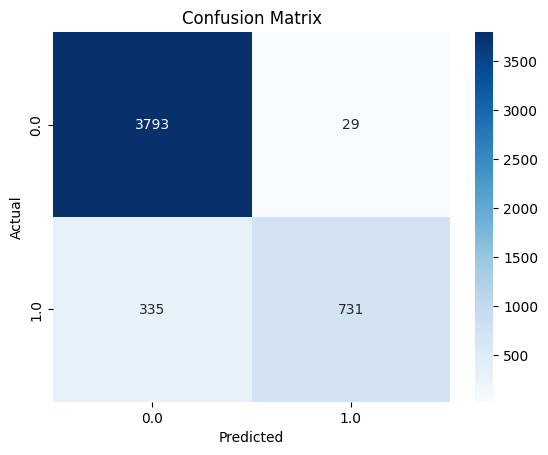

In [160]:
plot_confusion_matrix(y_test, yhat, labels=y_test.unique())

### 7.1.2 Random Forest Performance - Cross Validation

In [161]:
rf = RandomForestClassifier()
rf_cross_result = cross_validation_kfold(rf, X, y)

In [162]:
rf_cross_result

,model,precision,recall
0,RandomForestClassifier,0.959771,0.705891


## 7.2 Decision Tree

In [163]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

yhat_dt = dt.predict(X_test)


### 7.2.1 Decision Tree Performance

In [164]:
print( precision_score(y_test, yhat_dt) )
print( recall_score(y_test, yhat_dt) )

0.7502374169040835
0.7410881801125704


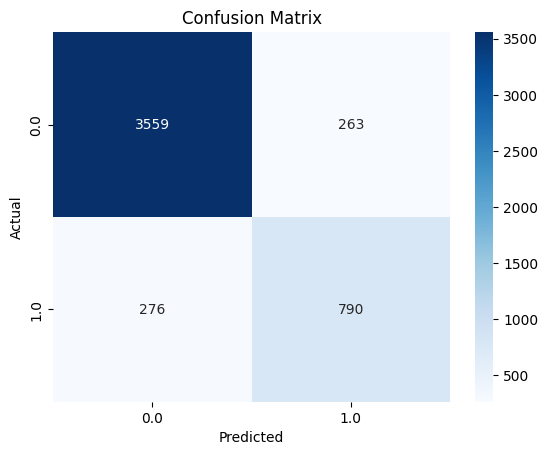

In [165]:
plot_confusion_matrix(y_test, yhat_dt, labels=y_test.unique())

### 7.2.2 Decision Tree Performance - Cross Validation

In [166]:
dt = DecisionTreeClassifier()
dt_cross_result = cross_validation_kfold(dt, X, y)

In [167]:
dt_cross_result

,model,precision,recall
0,DecisionTreeClassifier,0.732199,0.761236


## 7.3 LightGBM Classifier

In [168]:
lg = lgb.LGBMClassifier()

lg.fit(X_train, y_train)
yhat_lg = lg.predict(X_test)


[LightGBM] [Info] Number of positive: 6042, number of negative: 21651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2214
[LightGBM] [Info] Number of data points in the train set: 27693, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218178 -> initscore=-1.276317
[LightGBM] [Info] Start training from score -1.276317


### 7.3.1 LightGBM Performance

In [169]:
print( precision_score(y_test, yhat_lg) )
print( recall_score(y_test, yhat_lg) )

0.9793014230271668
0.7101313320825516


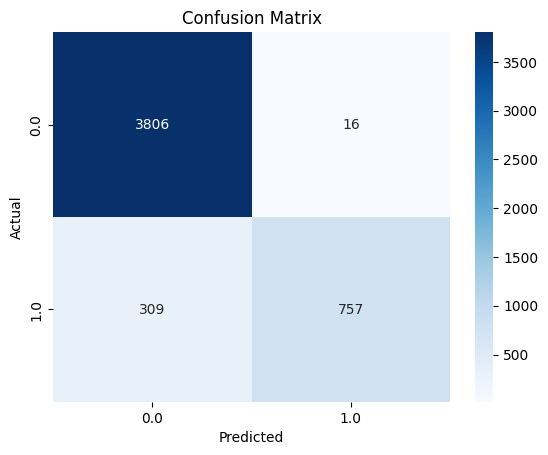

In [170]:
plot_confusion_matrix(y_test, yhat_lg, labels=y_test.unique())

### 7.3.2 LightGBM Performance - Cross Validation

In [171]:
lg = lgb.LGBMClassifier()
lg_cross_result = cross_validation_kfold(lg, X, y)

[LightGBM] [Info] Number of positive: 6846, number of negative: 24648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 31494, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217375 -> initscore=-1.281031
[LightGBM] [Info] Start training from score -1.281031
[LightGBM] [Info] Number of positive: 6839, number of negative: 24656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2216
[LightGBM] [Info] Number of data points in the train set: 31495, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217146 -> initscore=-1.282379
[LightGBM] [Info] Start training from score -1.282379
[LightGBM] [In

In [172]:
lg_cross_result

,model,precision,recall
0,LGBMClassifier,0.978718,0.725049


## 7.4 XGBoost

In [173]:
# Criar o classificador XGBoost
xgb_classifier = xgb.XGBClassifier()

# Treinar o classificador
xgb_classifier.fit(X_train, y_train)

# Fazer previsões
yhat_xgb = xgb_classifier.predict(X_test)

### 7.4.1 XGBoost Performance

In [174]:
print( precision_score(y_test, yhat_xgb) )
print( recall_score(y_test, yhat_xgb) )

0.9712140175219024
0.7279549718574109


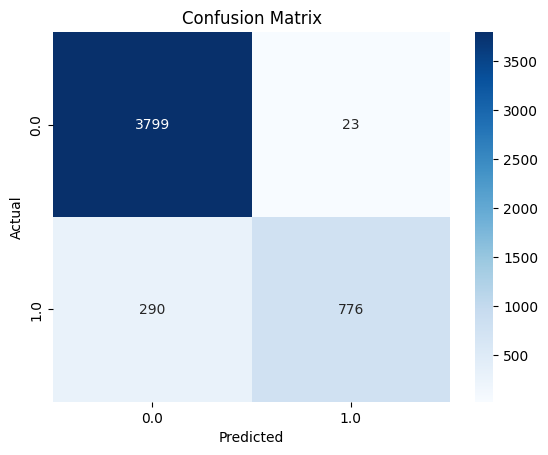

In [175]:
plot_confusion_matrix(y_test, yhat_xgb, labels=y_test.unique())

### 7.4.2 XGBoost Performance - Cross Validation

In [176]:
xgb_classifier = xgb.XGBClassifier()
xgb_cross_result = cross_validation_kfold(xgb_classifier, X, y)

In [177]:
xgb_cross_result

,model,precision,recall
0,XGBClassifier,0.961353,0.742335


## 7.5 Logistic Regression

In [178]:
# Criar o classificador XGBoost
lr = LogisticRegression()

# Treinar o classificador
lr.fit(X_train, y_train)

# Fazer previsões
yhat_lr = lr.predict(X_test)

c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 7.5.1 Logistic Regression Performance

In [179]:
print( precision_score(y_test, yhat_lr) )
print( recall_score(y_test, yhat_lr) )

0.7360912981455064
0.48405253283302063


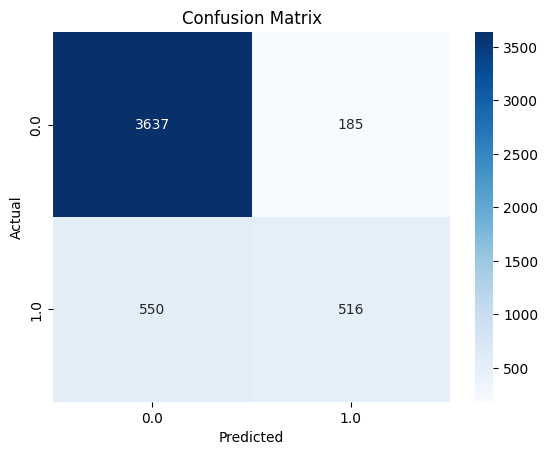

In [180]:
plot_confusion_matrix(y_test, yhat_lr, labels=y_test.unique())

### 7.5.2 Logistic Regression - Cross Validation

In [181]:
lr = LogisticRegression()
lr_cross_result = cross_validation_kfold(lr, X, y)

c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [182]:
lr_cross_result

,model,precision,recall
0,LogisticRegression,0.730506,0.469983


# All Results

In [183]:
df_all = pd.concat([rf_cross_result, dt_cross_result, lg_cross_result, xgb_cross_result, lr_cross_result])

In [184]:
df_all.sort_values('precision', ascending=False)

,model,precision,recall
0,LGBMClassifier,0.978718,0.725049
0,XGBClassifier,0.961353,0.742335
0,RandomForestClassifier,0.959771,0.705891
0,DecisionTreeClassifier,0.732199,0.761236
0,LogisticRegression,0.730506,0.469983


# 8.0 HyperParameter Fine Tunning

## 8.1 Grid Search

In [166]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 10, -1],  # -1 significa sem limite
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [169]:
# Inicializar o classificador LGBM
lgbm = lgb.LGBMClassifier(random_state=42)

# Inicializar a grade de pesquisa
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=2, scoring=['precision', 'recall'], refit='precision', verbose=2, n_jobs=-1)

# Executar a grade de pesquisa
grid_search.fit(X_train, y_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o desempenho do modelo no conjunto de teste
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precisão no conjunto de teste:", precision)
print("Recall no conjunto de teste:", recall)

Fitting 2 folds for each of 2187 candidates, totalling 4374 fits


KeyboardInterrupt: 

## 8.2 Random Search

In [172]:
# Inicializar a busca aleatória
random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid, n_iter=100, cv=2, scoring='precision', random_state=42, verbose=2, n_jobs=-1)

# Executar a busca aleatória
random_search.fit(X_train, y_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)

# Avaliar o desempenho do modelo no conjunto de teste
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precisão no conjunto de teste:", precision)
print("Recall no conjunto de teste:", recall)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 5272, number of negative: 19070
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 24342, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216580 -> initscore=-1.285707
[LightGBM] [Info] Start training from score -1.285707
Melhores parâmetros encontrados:
{'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 50, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Precisão no conjunto de teste: 1.0
Recall no conjunto de teste: 0.08807733619763695


## 8.3 Bayes Search

In [198]:
from bayes_opt import BayesianOptimization

# Definir a função de avaliação para otimização
def lgbm_cv(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, min_child_samples, num_leaves):
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_samples': int(min_child_samples),
        'num_leaves': int(num_leaves),
    }
    
    lgbm = lgb.LGBMClassifier(**params)
    cv_result = cross_val_score(lgbm, X_train, y_train, cv=5, scoring='precision').mean()
    
    return cv_result

# Definir os limites dos hiperparâmetros
pbounds = {
    'learning_rate': (0.01, 0.1),
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'min_child_samples': (10, 50),
    'num_leaves': (10, 50),
}

# Inicializar a busca Bayesiana
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds=pbounds,
    random_state=42,
)

# Executar a otimização
optimizer.maximize(init_points=5, n_iter=50)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(optimizer.max)

# Avaliar o modelo com os melhores parâmetros no conjunto de teste
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])
lgbm_best = lgb.LGBMClassifier(**best_params)
lgbm_best.fit(X_train, y_train)
precision = precision_score(y_test, lgbm_best.predict(X_test))
print("Precisão no conjunto de teste:", precision)


|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 4217, number of negative: 15256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 19473, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216556 -> initscore=-1.285849
[LightGBM] [Info] Start training from score -1.285849
[LightGBM] [Info] Number of positive: 4217, number of negative: 15256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_col_wise=true` to remove the o

In [199]:
best_params

{'colsample_bytree': 0.6290398848011625,
 'learning_rate': 0.013347021916471113,
 'max_depth': 6,
 'min_child_samples': 15,
 'n_estimators': 57,
 'num_leaves': 47,
 'subsample': 0.8751074697820468}

# 9.0 Final Model

In [474]:
best_params = {'colsample_bytree': 0.6290398848011625,
                'learning_rate': 0.013347021916471113,
                'max_depth': 6,
                'min_child_samples': 15,
                'n_estimators': 57,
                'num_leaves': 47,
                'subsample': 0.8751074697820468}

In [479]:
model_tunned = lgb.LGBMClassifier(**best_params).fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6042, number of negative: 21651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2214
[LightGBM] [Info] Number of data points in the train set: 27693, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218178 -> initscore=-1.276317
[LightGBM] [Info] Start training from score -1.276317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [480]:
y_hat = model_tunned.predict(X_test)

In [481]:
acc = accuracy_score(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)

print('Accuracy: ', acc)
print('Precision: ', precision)
print('Recall: ', recall)

Accuracy:  0.898936170212766
Precision:  1.0
Recall:  0.5365853658536586


In [482]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [483]:
final_model = lgb.LGBMClassifier(**best_params).fit(X_full, y_full)
pickle.dump( final_model, open( '../model/final_model.pkl', 'wb' ) )

[LightGBM] [Info] Number of positive: 7108, number of negative: 25473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2216
[LightGBM] [Info] Number of data points in the train set: 32581, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218164 -> initscore=-1.276398
[LightGBM] [Info] Start training from score -1.276398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


# 10.0 Tradução do Erro para Resultado de Negócio

In [215]:
# # Taxa de erro do Modelo Atual
taxa_erro_atual = 0.35

# # Taxa de erro do Novo Modelo
taxa_erro_novo = 1-precision  

# # Custo médio de inadimplência por empréstimo
custo_inadimplencia = 3000

# # Redução na taxa de erro com o novo modelo
reducao_taxa_erro = taxa_erro_atual - taxa_erro_novo

# # Economia por empréstimo com o novo modelo
economia_por_emprestimo = reducao_taxa_erro * custo_inadimplencia
print('Com o novo modelo, a empresa economiza por empréstimo: $', economia_por_emprestimo)

# # Base de clientes inicial
base_clientes_inicial = 100000

# # # Taxa de perda de clientes devido à inadimplência
taxa_perda_clientes = 0.10

# # # Número de clientes perdidos anualmente
clientes_perdidos_anualmente = base_clientes_inicial * taxa_perda_clientes

# # # Economia anual devido à redução na perda de clientes
economia_anual_perda_clientes = clientes_perdidos_anualmente * custo_inadimplencia
print('Com a performance do novo modelo, a empresa está economizando anualmente devido à redução na perda de clientes: $', economia_anual_perda_clientes)



Com o novo modelo, a empresa economiza por empréstimo: $ 1043.6440677966102
Com a performance do novo modelo, a empresa está economizando anualmente devido à redução na perda de clientes: $ 30000000.0


# 11.0 Deploy to Production

In [511]:
import pickle
from sklearn.impute import KNNImputer
class PredictEmprestimo(object):
    def __init__(self):
        self.finalidade_emprestimo_encoding                     = pickle.load(open('../parameter/finalidade_emprestimo_encoding.pkl', 'rb'))
        self.grau_risco_emprestimo_encoding                     = pickle.load(open('../parameter/grau_risco_emprestimo_encoding.pkl', 'rb'))
        self.posse_casa_encoding                                = pickle.load(open('../parameter/posse_casa_encoding.pkl', 'rb'))
        self.historico_credito_scaler                           = pickle.load(open('../parameter/historico_credito_scaler.pkl', 'rb'))
        self.idade_scaler                                       = pickle.load(open('../parameter/idade_scaler.pkl', 'rb'))
        self.proporcao_emprestimo_historico_credito_scaler      = pickle.load(open('../parameter/proporcao_emprestimo_historico_credito_scaler.pkl', 'rb'))
        self.proporcao_emprestimo_idade_scaler                  = pickle.load(open('../parameter/proporcao_emprestimo_idade_scaler.pkl', 'rb'))
        self.proporcao_emprestimo_tempo_emprego_scaler          = pickle.load(open('../parameter/proporcao_emprestimo_tempo_emprego_scaler.pkl', 'rb'))
        self.proporcao_renda_emprestimo_scaler                  = pickle.load(open('../parameter/proporcao_renda_emprestimo_scaler.pkl', 'rb'))
        self.relacao_emprestimo_renda_scaler                    = pickle.load(open('../parameter/relacao_emprestimo_renda_scaler.pkl', 'rb'))
        self.renda_scaler                                       = pickle.load(open('../parameter/renda_scaler.pkl', 'rb'))
        self.taxa_juros_ajustada_renda_scaler                   = pickle.load(open('../parameter/taxa_juros_ajustada_renda_scaler.pkl', 'rb'))
        self.taxa_juros_emprestimo_scaler                       = pickle.load(open('../parameter/taxa_juros_emprestimo_scaler.pkl', 'rb'))
        self.tempo_emprego_scaler                               = pickle.load(open('../parameter/tempo_emprego_scaler.pkl', 'rb'))
        self.valor_emprestimo_scaler                            = pickle.load(open('../parameter/valor_emprestimo_scaler.pkl', 'rb'))
        self.imputer                                            = pickle.load(open('../parameter/imputer_knn.pkl', 'rb'))
    def data_cleaning(self, df1):
        num_attributes = df1.select_dtypes(include=['int64','float64'])
        cat_attributes = df1.select_dtypes(include=['object','category'])
        if num_attributes.isnull().any().any():
            df_imputed = pd.DataFrame(self.imputer.transform(num_attributes), columns=num_attributes.columns)
            df1 = pd.concat([df_imputed, cat_attributes], axis=1) 
            return df1
        else:
            return df1

    def feature_engineering(self, df2):
        # Taxa de Juros Ajustada pela Renda
        df2['taxa_juros_ajustada_renda'] = df2['taxa_juros_emprestimo'] / df2['renda']

        # Proporção do Valor do Empréstimo em Relação à Idade
        df2['proporcao_emprestimo_idade'] = df2['valor_emprestimo'] / df2['idade']

        # Proporção do Valor do Empréstimo em Relação ao Tempo de Emprego
        df2['tempo_emprego'] = np.where(df2['tempo_emprego'] == 0, 1, df2['tempo_emprego'])
        df2['proporcao_emprestimo_tempo_emprego'] = df2['valor_emprestimo'] / df2['tempo_emprego']


        # Proporção do Valor do Empréstimo em Relação à História de Crédito
        df2['proporcao_emprestimo_historico_credito'] = df2['valor_emprestimo'] / df2['historico_credito']

        # Proporção da Renda em Relação ao Valor do Empréstimo
        df2['proporcao_renda_emprestimo'] = df2['renda'] / df2['valor_emprestimo']

        return df2 
    
    def data_preparation(self, df5):

        df5['finalidade_emprestimo']                     = self.finalidade_emprestimo_encoding.transform(df5['finalidade_emprestimo'])              
        df5['grau_risco_emprestimo']                     =  self.grau_risco_emprestimo_encoding.transform(df5['grau_risco_emprestimo'])               
        df5['posse_casa']                                =  self.posse_casa_encoding.transform(df5['posse_casa'])                            
        df5['historico_credito']                         =  self.historico_credito_scaler.transform(df5[['historico_credito']].values)                       
        df5['idade']                                     = self.idade_scaler.transform(df5[['idade']].values)                                   
        df5['proporcao_emprestimo_historico_credito']    =  self.proporcao_emprestimo_historico_credito_scaler.transform(df5[['proporcao_emprestimo_historico_credito']].values)  
        df5['proporcao_emprestimo_idade']                =  self.proporcao_emprestimo_idade_scaler.transform(df5[['proporcao_emprestimo_idade']].values)              
        df5['proporcao_emprestimo_tempo_emprego']        =  self.proporcao_emprestimo_tempo_emprego_scaler.transform(df5[['proporcao_emprestimo_tempo_emprego']].values)      
        df5['proporcao_renda_emprestimo']                =  self.proporcao_renda_emprestimo_scaler.transform(df5[['proporcao_renda_emprestimo']].values)              
        df5['relacao_emprestimo_renda']                  =  self.relacao_emprestimo_renda_scaler.transform(df5[['relacao_emprestimo_renda']].values)                
        df5['renda']                                     = self.renda_scaler.transform(df5[['renda']].values)                                   
        df5['taxa_juros_ajustada_renda']                 = self.taxa_juros_ajustada_renda_scaler.transform(df5[['taxa_juros_ajustada_renda']].values)               
        df5['taxa_juros_emprestimo']                     = self.taxa_juros_emprestimo_scaler.transform(df5[['taxa_juros_emprestimo']].values)                   
        df5['tempo_emprego']                             = self.tempo_emprego_scaler.transform(df5[['tempo_emprego']].values)                           
        df5['valor_emprestimo']                          = self.valor_emprestimo_scaler.transform(df5[['valor_emprestimo']].values)

        chosen_features = ['proporcao_renda_emprestimo', 'relacao_emprestimo_renda',
                            'grau_risco_emprestimo', 'posse_casa', 'taxa_juros_emprestimo',
                            'taxa_juros_ajustada_renda', 'renda', 'finalidade_emprestimo',
                            'proporcao_emprestimo_tempo_emprego', 'proporcao_emprestimo_idade',
                            'tempo_emprego', 'valor_emprestimo',
                            'proporcao_emprestimo_historico_credito', 'idade', 'historico_credito']

        return df5[chosen_features]

    def get_predictions(self, model, test_data):
        pred = model.predict( test_data )
        return pred



        
        

# API Handler

In [512]:
data_test = df1.loc[df1.index == 0]
model = pickle.load( open( '../model/final_model.pkl', 'rb') )
pe = PredictEmprestimo()


In [504]:
df_cleaning = pe.data_cleaning(data_test)

df_feature = pe.feature_engineering(df_cleaning)

df_preparation = pe.data_preparation(df_feature)

df_predict = pe.get_predictions(model, df_preparation)

C:\Users\thale\AppData\Local\Temp\ipykernel_6940\340104157.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['taxa_juros_ajustada_renda'] = df2['taxa_juros_emprestimo'] / df2['renda']
C:\Users\thale\AppData\Local\Temp\ipykernel_6940\340104157.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['proporcao_emprestimo_idade'] = df2['valor_emprestimo'] / df2['idade']
C:\Users\thale\AppData\Local\Temp\ipykernel_6940\340104157.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [505]:
df_predict

array([1.])

In [506]:
df.head()

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [509]:
# import pickle
# import pandas as pd
# from flask             import Flask, request, Response
# import sys
# sys.path.insert(0, '../')
# from api.empresa.empresa import PredictEmprestimo

# # loading model
# model = pickle.load( open( '../model/final_model.pkl', 'rb') )

# # initialize API
# app = Flask( __name__ )

# @app.route( '/empresa/predict', methods=['POST'] )
# def rossmann_predict():
#     test_json = request.get_json()
   
#     if test_json: # there is data
#         if isinstance( test_json, dict ): # unique example
#             test_raw = pd.DataFrame( test_json, index=[0] )
            
#         else: # multiple example
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
#         # Instantiate Rossmann class
#         pipeline = PredictEmprestimo()
        
#         # data cleaning
#         #df1 = pipeline.data_cleaning( test_raw )
        
#         # feature engineering
#         df2 = pipeline.feature_engineering( df1 )
        
#         # data preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         # prediction
#         df_response = pipeline.get_prediction( model, test_raw )
        
#         return df_response
        
        
#     else:
#         return Response( '{}', status=200, mimetype='application/json' )

# if __name__ == '__main__':
#     app.run( '0.0.0.0' )

In [515]:
data_test = df1.loc[df1.index == 7]
model = pickle.load( open( '../model/final_model.pkl', 'rb') )

In [516]:
import json
import requests
data = json.dumps( data_test.to_dict( orient='records' ) )

url = 'http://127.0.0.1:5000/empresa/predict'
#url = 'https://rossmann-predicoes.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [517]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [518]:
d1

,idade,renda,tempo_emprego,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,historico_credito,posse_casa,finalidade_emprestimo,grau_risco_emprestimo,registro_inadimplencia,taxa_juros_ajustada_renda,proporcao_emprestimo_idade,proporcao_emprestimo_tempo_emprego,proporcao_emprestimo_historico_credito,proporcao_renda_emprestimo,prediction
0,0.032258,0.012501,0.036735,1.0,0.319663,1.0,0.53012,0.071429,3,3,1,N,0.034359,0.915912,0.19891,0.499013,0.000831,1.0
